<a href="https://colab.research.google.com/github/jarek-pawlowski/advanced-machine-learning/blob/main/mnist_in_3_flavours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of handwritten digits using various neural network models with PyTorch
* Multinomial classification task of images of handwritten digits (10 classes).
* The database has a training set of 60k examples, and a test set of 10k examples, each image is of 28x28 pixels size.
* The MNIST ("Modified National Institute of Standards and Technology") is the “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

## Model setup

Before we start we need to load libraries and setup the model parameters

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import neptune
from neptune.types import File
from getpass import getpass
import os

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [19]:
model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128 
# learning rate is how fast it will descend
model_args['lr'] = .095
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 50
# logging frequency
model_args['log_interval'] = 500

In [16]:
os.environ["NEPTUNE_PROJECT"] = "prince.canuma/ml-applications"
os.environ["NEPTUNE_API_TOKEN"] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vbmV3LXVpLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9uZXctdWkubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3ODkzZTcyNy02ZGRhLTQxYTktOWViZC1lNDE1M2Q4NTc3ZjYifQ=="

In [17]:
run = neptune.init_run(
    project="prince.canuma/ml-applications",
)

https://new-ui.neptune.ai/prince.canuma/ml-applications/e/MLAP-22


Let's start with loading the dataset and check how it looks like
> **In case of problems with downloading dataset via torchvison please use the second method**

In [5]:
# load the MINST dataset via torchvision 
transform = transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('../data', train=False, download=True, transform=transform)

Second method: directly download tar.gz archive
> many thanks to @Bartosz K.

In [6]:
# alternatively just download MNIST.tar.gz archive
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

transform = transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('./', train=False, download=True, transform=transform)

zsh:1: command not found: wget
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [7]:
# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 8, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

50000
10000
10000
391
torch.Size([28, 28])


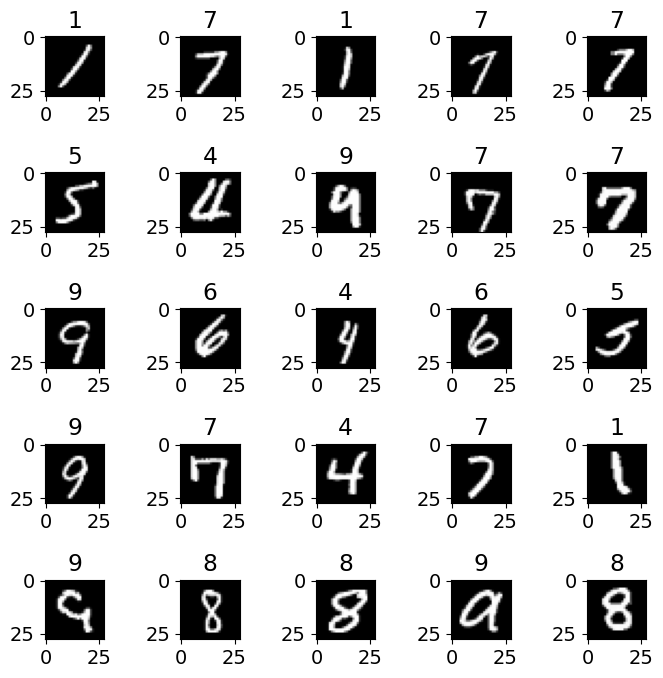

In [18]:
print(len(train_subset))
print(len(validation_subset))
print(len(test_subset)) # we have data already divided into train & validation & test subsets
print(len(train_loader)) # no of train batches
example_number = 123
print(train_subset[example_number][0][0].shape) # single item shape


fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        run["images"].append(File.as_image(train_subset[example_number+i*5+j][0].reshape(28,28).clip(0, 1)))
        axs[i,j].imshow(train_subset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        axs[i,j].set_title(train_subset[example_number+i*5+j][1])

Let's now construct the NN models:
- we start with siplest single layer **perceptron** with *softmax* activation,
- then test **deep** network with some (fully-connected) *hidden* layers,
- and finally setup deep **convolutional neural network**.

In [9]:
class Perceptron(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Perceptron, self).__init__()
        # fully connected layer
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class Deep(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Deep, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        # hidden layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class CNN(nn.Module):
    # this defines the structure of the CNN model
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer with 2 kernels of size 5x5
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3) 
        # 8 kernels of size 5x5
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        # 2D dropout
        self.conv2_drop = nn.Dropout2d()
        # fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # 1st layers group
        x = self.conv1(x) # resulting in 2 feature maps each of size 24x24
        x = F.relu(x) # standard (in CNNs) ReLU activation
        # 2nd group
        x = self.conv2(x) # resulting in 4 feature maps each of size 8x8
        x = F.max_pool2d(x, 2) # downsizing each map to 12x12
        x = F.relu(x) # standard (in CNNs) ReLU activation
        x = self.conv3(x)
        x = F.max_pool2d(x, 6)
        # 2nd group
        # x = self.conv2_drop(x) 
        # fully connected layers
        x = x.view(-1, 256) # 4 maps of 4x4 size gives 64 numbers
        x = self.fc1(x) # 64 -> 20
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training) # dropout is a type of regularization
        x = self.fc2(x) # 20 -> 10
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # dropout is a type of regularization
        x = self.fc3(x)
        # softmax (multinomial classification) gives probabilities of each class
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch


In [10]:
X_test, y_test = next(iter(test_loader))
model = CNN()
model(X_test).shape, y_test.shape

(torch.Size([128, 10]), torch.Size([128]))

And define training, testing, and plotting utils:

In [11]:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        run["metrics/train/loss"].append(loss)
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, message, validation=True):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean') 
            # get the index of class with the max log-probability 
            prediction = output.argmax(dim=1)  
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    if validation:
        run["metrics/validation/loss"].append(test_loss)
        run["metrics/validation/acc"].append(correct/100)
    else:
        run["metrics/test/loss"] = test_loss
        run["metrics/test/acc"] = correct/100
        run["metrics/test/acc_perc"] = 100. * correct / len(test_loader.dataset)
    return test_loss

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

## Experiments

1. At first let's test the single-layer *Perceptron* model



In [12]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.368947

Train set: Average loss: 0.3746
Validation set: Average loss: 0.3141, Accuracy: 9089/10000 (91%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.252204

Train set: Average loss: 0.3039
Validation set: Average loss: 0.3005, Accuracy: 9172/10000 (92%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.201697

Train set: Average loss: 0.2910
Validation set: Average loss: 0.2913, Accuracy: 9172/10000 (92%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.225625

Train set: Average loss: 0.2836
Validation set: Average loss: 0.2864, Accuracy: 9198/10000 (92%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.226489

Train set: Average loss: 0.2791
Validation set: Average loss: 0.2868, Accuracy: 9211/10000 (92%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.260535

Train set: Average loss: 0.2745
Validation set: Average loss: 0.2835, Accuracy: 9234/10000 (92%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.157800

Train set: Average loss: 0.2721
Validation set: Average loss: 0.2780, Accuracy: 9230/10000

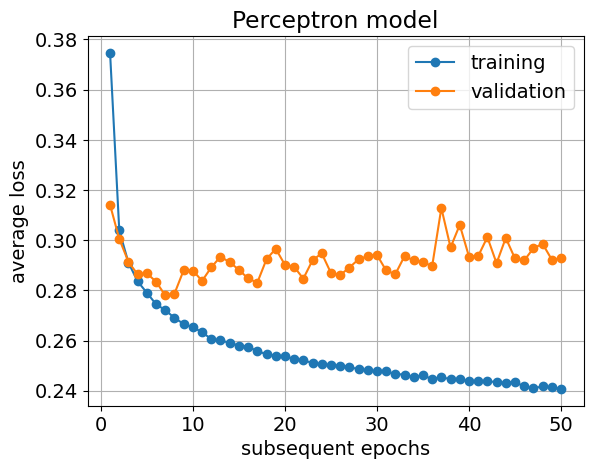

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/prince.canuma/ml-applications/e/MLAP-3/metadata


In [62]:
model = Perceptron().to(device)

run["params"] = model_args
run["params/dataloader"] = loader_kwargs

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

run["metrics/train/epoch_loss"].extend(train_loss)
run["metrics/validation/epoch_loss"].extend(validation_loss)

test(model, device, test_loader, 'Test set', validation=False)
plot_loss(train_loss, validation_loss, 'Perceptron model')
run.stop()

2. Now add a hidden layer to the *Perceptron* and evaluate the *Deep* model 

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.428825

Train set: Average loss: 0.3755
Validation set: Average loss: 0.2593, Accuracy: 9246/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.273530

Train set: Average loss: 0.2169
Validation set: Average loss: 0.2171, Accuracy: 9363/10000 (94%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.128283

Train set: Average loss: 0.1795
Validation set: Average loss: 0.1861, Accuracy: 9450/10000 (94%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.115986

Train set: Average loss: 0.1570
Validation set: Average loss: 0.1753, Accuracy: 9476/10000 (95%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.198614

Train set: Average loss: 0.1443
Validation set: Average loss: 0.1714, Accuracy: 9502/10000 (95%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.096685

Train set: Average loss: 0.1342
Validation set: Average loss: 0.1577, Accuracy: 9522/10000 (95%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.032487

Train set: Average loss: 0.1294
Validation set: Average loss: 0.1587, Accuracy: 9537/10000

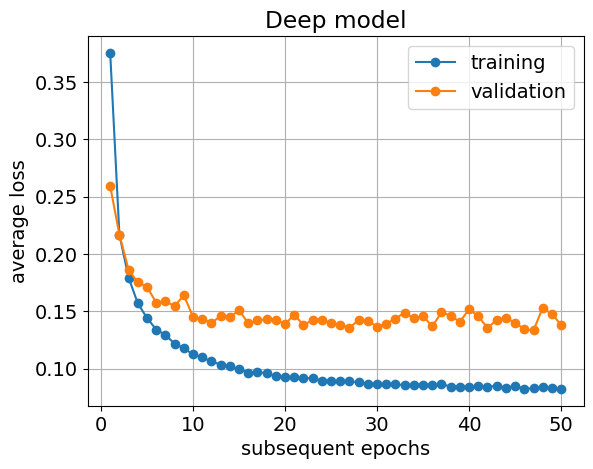

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/prince.canuma/ml-applications/e/MLAP-22/metadata


In [21]:
model = Deep().to(device)

run["params"] = model_args
run["params/dataloader"] = loader_kwargs

optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

run["metrics/train/epoch_loss"].extend(train_loss)
run["metrics/validation/epoch_loss"].extend(validation_loss)

test(model, device, test_loader, 'Test set', validation=False)
plot_loss(train_loss, validation_loss, 'Deep model')
run_id = run["sys/id"].fetch()
run.stop()

3. Compare these results with a deep convolutional network, which is more useful in real-world problems:

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.315615

Train set: Average loss: 1.0218
Validation set: Average loss: 0.2401, Accuracy: 9274/10000 (93%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.269741

Train set: Average loss: 0.2380
Validation set: Average loss: 0.1458, Accuracy: 9589/10000 (96%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.191943

Train set: Average loss: 0.1702
Validation set: Average loss: 0.1121, Accuracy: 9669/10000 (97%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.130942

Train set: Average loss: 0.1361
Validation set: Average loss: 0.1084, Accuracy: 9688/10000 (97%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.047645

Train set: Average loss: 0.1185
Validation set: Average loss: 0.1009, Accuracy: 9700/10000 (97%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.074434

Train set: Average loss: 0.1068
Validation set: Average loss: 0.0983, Accuracy: 9742/10000 (97%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.052901

Train set: Average loss: 0.0977
Validation set: Average loss: 0.0802, Accuracy: 9759/10000

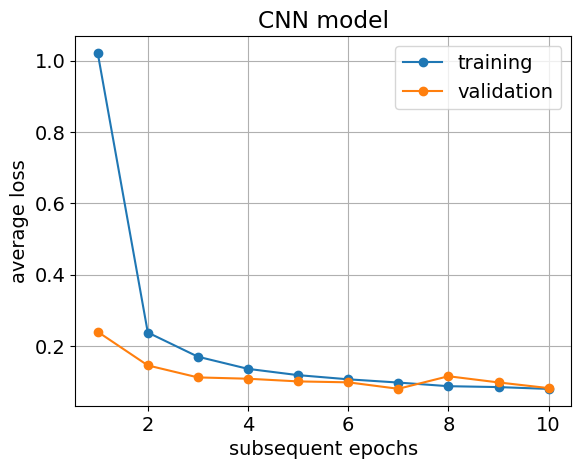

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/prince.canuma/ml-applications/e/MLAP-20/metadata


In [15]:
model = CNN().to(device)

run["params"] = model_args
run["params/dataloader"] = loader_kwargs

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'], weight_decay=1.e-3) 
# optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))


run["metrics/train/epoch_loss"].extend(train_loss)
run["metrics/validation/epoch_loss"].extend(validation_loss)

test(model, device, test_loader, 'Test set', validation=False)
plot_loss(train_loss, validation_loss, 'CNN model')
run_id = run["sys/id"].fetch()
run.stop()

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [23]:
X_test, y_test = next(iter(test_loader))
model.eval()
preds = model(X_test).argmax(dim=1) 

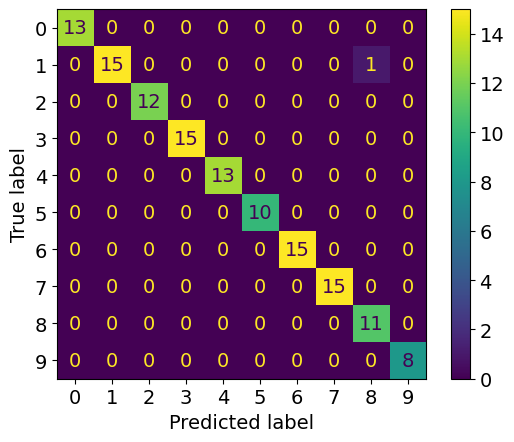

In [24]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=[i for i in range(10)])
plt.show()

In [25]:
PATH = "model.pt"

torch.save({
            'epoch': model_args["epochs"],
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

In [26]:
run = neptune.init_run(
    project="prince.canuma/ml-applications",
    with_id=run_id
)
run["model/checkpoint"].upload("model.pt")
run["confusion_matrix"].upload(disp.figure_)
run.stop()

https://new-ui.neptune.ai/prince.canuma/ml-applications/e/MLAP-22
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/prince.canuma/ml-applications/e/MLAP-22/metadata


## Summary
* *Deep* and *CNN* models with accuracies of 96% and 97% (evaluated on the test subset) perform much better than single-layer *Perceptron* with 92%;
* The two smallest (and simplest) models appear to be overfitted. To deal with this we need to apply some regularization.
* Validation subset is evaluated during the training (as opposed to test set, infered *after* the training) in order to tune the model hiperparameters (that describe e.g. the network structure, or training details).
* A moment to stop trainning is a kind of hipermarameter -- by applying *early stopping* we can avoid overfitting.



## Tasks to do
* apply some regularization technique to *Deep* model in order to avoid overfitting (start with nonzero *weight_decay* in optimizer)
* try to figure out why the validation loss for *CNN* model turns to be *lower* than the train loss (hint: turn off regularization),
* **tune one of these models to get the *Test Set Accuracy* > 99%**,
* plot the *confusion matrix* among all of the classes---which of digits are mostly confused with each other?
>How to build the confusion matrix?
> * for example 1st row represents images with "0" digit (*ground truth*), while 1st colum images for which the model *predicts* "0",
> * this way element _11 is equal to number of images with "0" corectly clasified as "0" (true positives), while _15 number of images with "0" wrongly calssified as "4", and so on.
* and finally prepare report.

### How the report should look like
* 1-2 page long
* shortly describe what modifications you apply
* justyfy in a few words why your improved model is so cool
* results should be presented as plots with multiline captions